<table width="100%" border="3">
  <tbody>
    <tr>
      <td ><img src="https://aidea-web.tw/images/web/logo_white.png" alt="Aidea" width="400"/></td>
      <td align='left'><h1>Exercise 5: Visual Recheck </h1></td>
    </tr>
  </tbody>
</table>

# Exercise 5: Explain predictions with Grad-CAM
https://medium.com/手寫筆記/grad-cam-introduction-d0e48eb64adb
<img src="https://i.imgur.com/APqyQP9.png">

#(A) Ensemble Method

## Step 1: Load AIdea AOI dataset

In [1]:
#load AIdea AOI dataset
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='1Arcy_6pkMwLrg05A4f8S5dRzyu4I5j8Q',dest_path='./content', unzip=True)

Unzipping...Done.


## Step 2: Import python libraries

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

## Step 3: Load pretrained models:
* m1: auaoi-InceptionResNetV2
* m2: auaoi-InceptionV3
* m3: auaoi-Xception

In [5]:
#load AIdea AOI trained CNN models
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='1sh735v1fkLU3EC-xZCIq6mmvYkKyRUq9',dest_path='./model', unzip=True)

Unzipping...Done.


In [6]:
model_files = ['m1.h5', 'm2.h5', 'm3.h5']
renames = ['a', 'b', 'c']
models = []
for file in model_files:
  model = tf.keras.models.load_model(file)
  models.append(model)


## Step 4: read the training set

In [7]:
import pandas as pd
df_train = pd.read_csv("train.csv",dtype=str)
print(df_train.shape)

(2528, 2)


In [ ]:
df_train.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [8]:
train_num = df_train.shape[0]
train_files = df_train.iloc[:train_num,0].values
train_labels = df_train.iloc[:train_num,1].values
print(train_labels[:20])

['0' '1' '1' '5' '5' '5' '3' '0' '3' '5' '3' '5' '3' '3' '1' '1' '1' '1'
 '5' '1']


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


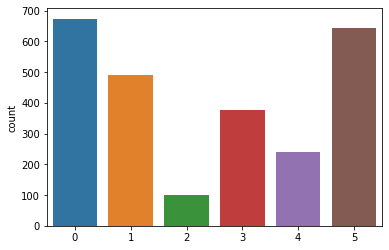

In [9]:
import seaborn as sns
g = sns.countplot(train_labels)

In [ ]:
num_classes=6

## Step 5: Set up an ImageDataGenerator and a Train_generator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
#from tensorflow.keras.applications.inception_v3 import preprocess_input
img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train_generator = img_gen.flow_from_dataframe(dataframe=df_train,
            directory="train_images",
            x_col="ID",
            y_col="Label",
            subset=None,
            batch_size=8,
            shuffle=False,
            class_mode="categorical",
            color_mode="rgb",
            target_size=(299,299))
print(train_generator.n)

Found 2528 validated image filenames belonging to 6 classes.
2528


In [12]:
train_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}

In [13]:
if train_generator.n % train_generator.batch_size ==0:
  step_size_train=train_generator.n//train_generator.batch_size
else:
  step_size_train=train_generator.n//train_generator.batch_size + 1
print(step_size_train)

316


## Step 6: Evaluation of pretrained models with the training set

In [14]:
##Evaluation of pretrained models
for model in models:
    train_generator.reset()
    model.evaluate_generator(generator=train_generator, steps=step_size_train, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
316/316 [==============================] - 50s 159ms/step - loss: 0.0069 - accuracy: 0.9980


## Step 7: Prediction of pretrained models with the training set

In [15]:
#y_predictions = model.predict(X_train, batch_size=20)
y_predictions_All = []
for model in models:
    train_generator.reset()
    y_predictions = model.predict_generator(generator=train_generator, steps=step_size_train, verbose=1)
    y_predictions_All.append(y_predictions)

Instructions for updating:
Please use Model.predict, which supports generators.
316/316 [==============================] - 50s 157ms/step


## Step 8: Confusion matrices of pretrained models with the training set

In [16]:
labels = train_labels.astype(int)
print(labels[:10])

[0 1 1 5 5 5 3 0 3 5]


In [17]:
from sklearn.metrics import confusion_matrix
predicts_all = []
for y_predictions in y_predictions_All:
    predicts = np.argmax(y_predictions,axis=1)
    predicts_all.append(predicts)
    confusion=confusion_matrix(labels, predicts)
    print(confusion)

[[674   0   0   0   0   0]
 [  5 482   0   3   1   1]
 [  1   0  99   0   0   0]
 [  0   0   0 376   2   0]
 [  0   0   0   2 238   0]
 [  0   0   0   0   0 644]]
[[674   0   0   0   0   0]
 [  1 490   0   0   1   0]
 [  0   0 100   0   0   0]
 [  0   0   0 377   1   0]
 [  0   0   0   1 239   0]
 [  0   2   0   0   0 642]]
[[674   0   0   0   0   0]
 [  1 490   0   1   0   0]
 [  0   0 100   0   0   0]
 [  0   0   0 377   1   0]
 [  0   0   0   2 238   0]
 [  0   0   0   0   0 644]]


## Step 9: Show differences of predictions between the models

In [18]:
for i in range(len(labels)):
    label=labels[i]
    file=train_files[i]
    pred0=predicts_all[0][i]
    pred1=predicts_all[1][i]
    pred2=predicts_all[2][i]
    if label!=pred0 or label!=pred1 or label!=pred2:
        print(f'{file}:{label}->({pred0}, {pred1}, {pred2})')

train_00257.png:4->(4, 4, 3)
train_00395.png:1->(1, 0, 1)
train_00405.png:1->(0, 1, 0)
train_00540.png:4->(3, 3, 3)
train_00908.png:1->(5, 1, 1)
train_00921.png:5->(5, 1, 5)
train_00973.png:1->(0, 1, 1)
train_01394.png:3->(4, 3, 3)
train_01569.png:1->(0, 1, 1)
train_01589.png:3->(4, 3, 3)
train_01725.png:1->(3, 1, 3)
train_01781.png:1->(3, 1, 1)
train_02005.png:1->(3, 1, 1)
train_02015.png:4->(3, 4, 4)
train_02053.png:1->(0, 1, 1)
train_02066.png:1->(1, 4, 1)
train_02074.png:5->(5, 1, 5)
train_02162.png:3->(3, 4, 3)
train_02163.png:1->(0, 1, 1)
train_02238.png:1->(4, 1, 1)
train_02308.png:2->(0, 2, 2)
train_02350.png:3->(3, 3, 4)


In [31]:
for i in range(len(labels)):
    label=labels[i]
    file=train_files[i]
    pred0=predicts_all[0][i]
    pred1=predicts_all[1][i]
    pred2=predicts_all[2][i]
    ypred0=y_predictions_All[0][i][pred0]
    ypred1=y_predictions_All[1][i][pred1]
    ypred2=y_predictions_All[2][i][pred2]
    if (ypred0 < 0.95) and (ypred1 < 0.95) and (ypred2 <0.95):
        print(f'{file}:{label}->({pred0}:{ypred0}, {pred1}:{ypred1}, {pred2}:{ypred2})')

train_00908.png:1->(5:0.8379673361778259, 1:0.9439351558685303, 1:0.6123632788658142)
train_01725.png:1->(3:0.757510781288147, 1:0.9095394611358643, 3:0.6135988235473633)
train_02129.png:4->(4:0.9362788200378418, 4:0.33983975648880005, 4:0.6728262901306152)


#(B) Visual Recheck

## Step10: Show images

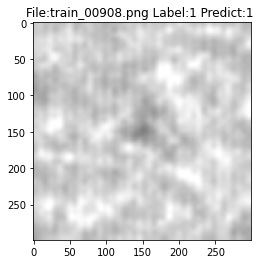

In [30]:
from tensorflow.keras.preprocessing import image
sel = 908
file = train_files[sel]
label= train_labels[sel]
pred = predicts[sel]
img = image.load_img("train_images/"+file, color_mode="rgb", target_size = (299, 299))
fig,ax=plt.subplots(1,1)
ax.imshow(img, cmap='gray')
ax.set_title('File:{} Label:{} Predict:{} '.format(file, label, pred))   
plt.show()  

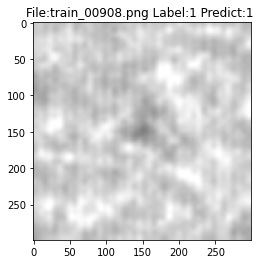

In [62]:
sel = 908
file = train_files[sel]
label= train_labels[sel]
pred = predicts[sel]
img = image.load_img("train_images/"+file, color_mode="rgb", target_size = (299, 299))
fig,ax=plt.subplots(1,1)
ax.imshow(img, cmap='gray')
ax.set_title('File:{} Label:{} Predict:{} '.format(file, label, pred))   
plt.show()  

In [49]:
grad_models=[]

In [ ]:
#Model: "inception_resnet_v2"
models[0].summary()

In [50]:
grad_model0 = Model([models[0].inputs], [models[0].get_layer('conv_7b_ac').output, models[0].output])
grad_models.append(grad_model0)

In [ ]:
#Model: "inception_v3"
models[1].summary()

In [51]:
grad_model1 = Model([models[1].inputs], [models[1].get_layer('mixed10').output, models[1].output])
grad_models.append(grad_model1)

In [ ]:
#Model: "xception"
models[2].summary()

In [52]:
grad_model2 = Model([models[2].inputs], [models[2].get_layer('block14_sepconv2_act').output, models[2].output])
grad_models.append(grad_model2)

In [56]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

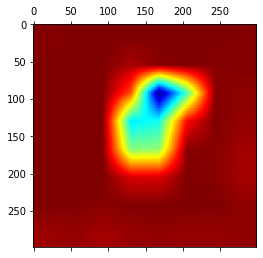

In [61]:
grad_model = grad_model0
sel = 908
pred= 5
file = train_files[sel]
label= train_labels[sel]
img = image.load_img("train_images/"+file, color_mode="rgb", target_size = (299, 299))
x = image.img_to_array(img)
img_array = preprocess_input(x, mode = 'tf' )

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img_array]))
    loss = predictions[:, pred]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (299, 299))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
# Display heatmap
plt.matshow(cam)
plt.show()

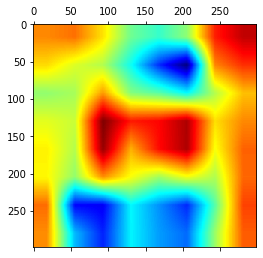

In [64]:
grad_model = grad_model1
sel = 908
pred= 1
file = train_files[sel]
label= train_labels[sel]
img = image.load_img("train_images/"+file, color_mode="rgb", target_size = (299, 299))
x = image.img_to_array(img)
img_array = preprocess_input(x, mode = 'tf' )

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img_array]))
    loss = predictions[:, pred]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (299, 299))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
# Display heatmap
plt.matshow(cam)
plt.show()

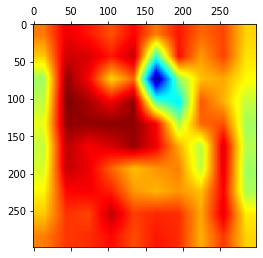

In [65]:
grad_model = grad_model2
sel = 908
pred= 1
file = train_files[sel]
label= train_labels[sel]
img = image.load_img("train_images/"+file, color_mode="rgb", target_size = (299, 299))
x = image.img_to_array(img)
img_array = preprocess_input(x, mode = 'tf' )

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img_array]))
    loss = predictions[:, pred]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (299, 299))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
# Display heatmap
plt.matshow(cam)
plt.show()